# Exploratory Analysis of Fund 5 CA Assessments

## Load packages.

In [1]:
require(data.table)
require(MASS)
require(cluster)
require(magrittr)
require(PerMallows)

require(ggplot2)
require(ggdendro)

Loading required package: data.table
Loading required package: MASS
Loading required package: cluster
Loading required package: magrittr
Loading required package: PerMallows
Loading required package: Rcpp
Loading required package: ggplot2
Loading required package: ggdendro


In [2]:
options(repr.plot.height=4)

## Read data.

### Read CA assessments.

In [3]:
assessments <- fread("f5-assessments.tsv")
assessments %>% summary

 Unique Proposal ID     CA ID         Proposal ID      Question ID   
 Length:5416        Min.   :  1.00   Min.   :350599   Min.   :1.000  
 Class :character   1st Qu.: 22.00   1st Qu.:350984   1st Qu.:1.000  
 Mode  :character   Median : 46.00   Median :352002   Median :2.000  
                    Mean   : 62.14   Mean   :351793   Mean   :2.348  
                    3rd Qu.: 71.00   3rd Qu.:352549   3rd Qu.:3.000  
                    Max.   :255.00   Max.   :352830   Max.   :6.000  
     Score        Flagged       
 Min.   :1.000   Mode :logical  
 1st Qu.:2.000   FALSE:4172     
 Median :4.000   TRUE :1244     
 Mean   :3.299                  
 3rd Qu.:5.000                  
 Max.   :5.000                  

### Read which proposals belong to which challenges.

In [4]:
challenges <- fread("f5-challenges.tsv")
challenges %>% summary

  Challenge          Proposal ID     Short Title       
 Length:321         Min.   :350599   Length:321        
 Class :character   1st Qu.:351008   Class :character  
 Mode  :character   Median :352005   Mode  :character  
                    Mean   :351820                     
                    3rd Qu.:352562                     
                    Max.   :355448                     

### Check to make sure that every proposal belongs to a challenge.

In [5]:
setdiff(assessments$`Proposal ID`, challenges$`Proposal ID`)

integer(0)

### Join the assessment data with the challenge data.

In [6]:
f5 <- merge(assessments, challenges, allow.cartesian=TRUE)
f5[1:10, ]

Proposal ID,Unique Proposal ID,CA ID,Question ID,Score,Flagged,Challenge,Short Title
<int>,<chr>,<int>,<int>,<int>,<lgl>,<chr>,<chr>
350599,UM5UZBiNh,1,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,2,1,3,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,9,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,11,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,13,1,4,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,14,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,15,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,16,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,18,1,4,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code


## CA activity by number of assessments and challenges.

In [7]:
f5.assessments_by_ca <- f5[, .(
    `Number of Assessments` = .N,
    `Number of Challenges` = factor(length(unique(`Challenge`)), levels=1:10)
), by = `CA ID`]
f5.assessments_by_ca %>% summary

     CA ID       Number of Assessments Number of Challenges
 Min.   :  1.0   Min.   :  1.00        1      :44          
 1st Qu.: 54.5   1st Qu.:  6.00        2      :35          
 Median :126.5   Median : 12.00        3      :22          
 Mean   :122.1   Mean   : 39.25        8      :11          
 3rd Qu.:183.8   3rd Qu.: 30.00        4      :10          
 Max.   :255.0   Max.   :798.00        6      : 6          
                                       (Other):10          

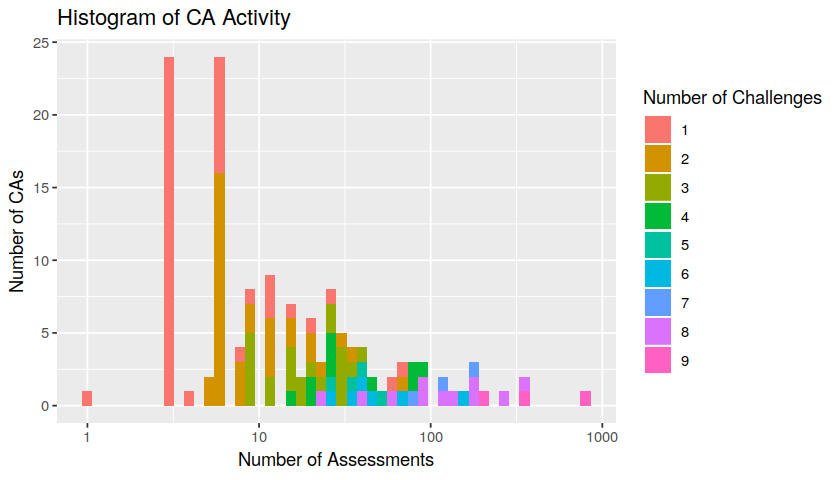

In [8]:
ggplot(f5.assessments_by_ca, aes(x = `Number of Assessments`,fill = `Number of Challenges`)) +
    geom_histogram(bins = 50) +
    scale_x_log10() +
    ylab("Number of CAs") +
    ggtitle("Histogram of CA Activity")

## High/low scoring patterns.

### CAs whose only five-star scores went to a single proposal.

In [9]:
f5.five_stars_only_one <- f5[
    `Score` == 5,
    .(`Number of Unique Proposals` = length(unique(`Unique Proposal ID`))),
    by = `CA ID`
][`Number of Unique Proposals` == 1, .(`CA ID`)]
f5.five_stars_only_one

CA ID
<int>
64
146
115
128
132
130
138
157
158


### How they scored other proposals.

In [10]:
f5.score_by_ca <- merge(
    f5.assessments_by_ca[`CA ID` %in% f5.five_stars_only_one[, `CA ID`], .(`CA ID`, `Number of Challenges`)],
    dcast(f5[, .N, by = .(`CA ID`, `Score`)], `CA ID` ~ `Score`, value.var = "N", fill = 0),
    by = "CA ID"
)
colnames(f5.score_by_ca) <- c("CA ID", "Number of Challenges", "Score 1", "Score 2", "Score 3", "Score 4", "Score 5")
f5.score_by_ca[order(`Number of Challenges`, - `Score 1`, - `Score 2`, - `Score 3`, - `Score 4`)]

CA ID,Number of Challenges,Score 1,Score 2,Score 3,Score 4,Score 5
<int>,<fct>,<int>,<int>,<int>,<int>,<int>
64,1,3,0,0,1,2
255,1,0,1,1,2,2
229,1,0,1,1,0,1
190,1,0,0,2,3,1
128,1,0,0,1,3,2
254,1,0,0,1,1,1
115,1,0,0,0,1,2
182,1,0,0,0,1,2
138,1,0,0,0,0,3


### Cases where the CA scored one proposal highly, and all other proposals received low scores.

In [11]:
f5[`CA ID` %in% c(64,199,202,192)][order(`CA ID`, `Unique Proposal ID`, `Question ID`)]

Proposal ID,Unique Proposal ID,CA ID,Question ID,Score,Flagged,Challenge,Short Title
<int>,<chr>,<int>,<int>,<int>,<lgl>,<chr>,<chr>
350661,UM5UZBiOi,64,1,5,FALSE,DApps Integrations,ChainEscrow On chain escrow dApp
350661,UM5UZBiOi,64,2,4,FALSE,DApps Integrations,ChainEscrow On chain escrow dApp
350661,UM5UZBiOi,64,3,5,FALSE,DApps Integrations,ChainEscrow On chain escrow dApp
351002,UM5UZBiUI,64,1,1,FALSE,DApps Integrations,Decentralised maps and nfts
351002,UM5UZBiUI,64,2,1,FALSE,DApps Integrations,Decentralised maps and nfts
351002,UM5UZBiUI,64,3,1,FALSE,DApps Integrations,Decentralised maps and nfts
352014,UM5UZBilt,192,1,2,FALSE,Defi Ecosystem,Daedalus Wallet Node SBC Devices
352014,UM5UZBilt,192,2,1,FALSE,Defi Ecosystem,Daedalus Wallet Node SBC Devices
352014,UM5UZBilt,192,3,1,FALSE,Defi Ecosystem,Daedalus Wallet Node SBC Devices


### Cases where the CA scored only one proposal and gave it five stars.

In [12]:
f5.score_by_ca[`Score 1` + `Score 2` + `Score 3` + `Score 4` == 0, .(`CA ID`)]

CA ID
<int>
138
158
159
161
166
169
172
212
218


## Estimating the influence of CAs.

### Would the proposal with the highest score in each challenge change if all of a CA's assessments were eliminated?

In [13]:
# Function that computes the $N$ top-ranked proposals in each challenge.

topRanked <- function(f5x, count = 1) {
    meanScores <- f5x[, .(
        `Mean Score` = mean(`Score`)
    ), by = .(
        `Challenge`,
        `Unique Proposal ID`
    )][order(`Challenge`, - `Mean Score`)]
    topScores <- meanScores[, .(
        `Unique Proposal ID`,
        Rank = sequence(.N)
    ), by = .(`Challenge`)]
    topScores[`Rank` <= count]$`Unique Proposal ID`
}

In [14]:
# Function that computes how many top rankings would change if a CA had not made any assessments.

changesTop <- function(caId, count = 1, f5x = f5) {
    before <- topRanked(f5x, count)
    after <- topRanked(f5x[`CA ID` != 1], count)
    length(setdiff(before, after))
}

#### It turns out that for Fund 5, eliminating any single CA's assessments would not change the list of highest-scored proposals in any challenge.

In [15]:
f5[, .(
    `Number of Highest-Score Proposals that Change when CA is Eliminated` = mapply(changesTop, `CA ID`)
), by = .(`CA ID`)][
    `Number of Highest-Score Proposals that Change when CA is Eliminated` > 0
]

CA ID,Number of Highest-Score Proposals that Change when CA is Eliminated
<int>,<int>


#### Even the set of the highest-scored nine proposals in each challenge doesn't change if any particular CA's assessments are all eliminated.

In [16]:
f5[, .(
    `Number of Top 9 Proposals that Change when CA is Eliminated` = mapply(changesTop, `CA ID`, 9)
), by = .(`CA ID`)][
    `Number of Top 9 Proposals that Change when CA is Eliminated` > 0
]

CA ID,Number of Top 9 Proposals that Change when CA is Eliminated
<int>,<int>


#### However, the set of the ten highest-scored proposals in each challenge does change if any of 138 CA's assessments are all eliminated.

In [17]:
f5[, .(
    `Number of Top 10 Proposals that Change when CA is Eliminated` = mapply(changesTop, `CA ID`, 10)
), by = .(`CA ID`)][
    `Number of Top 10 Proposals that Change when CA is Eliminated` > 0
] %>% nrow

[1] 138

### How much would eliminating a CA's assessment perturb the score-ordered list of proposals in each challenge?

In [18]:
# Function that computes how much the ranking of all proposals would change if a CA had not made any assessments.

changesRanks <- function(caId, f5x = f5) {
    before <- f5x[, .(
        `Mean Score` = mean(`Score`)
    ), by = .(
        `Challenge`,
        `Unique Proposal ID`
    )][
        order(`Challenge`, - `Mean Score`)
    ][, .(
        `Unique Proposal ID`,
        `Rank with CA` = sequence(.N)
    ), by = .(
        `Challenge`
    )]
    after <- f5x[
        `CA ID` != caId
    ][, .(
        `Mean Score` = mean(`Score`)
    ), by = .(
        `Challenge`,
        `Unique Proposal ID`
    )][
        order(`Challenge`, - `Mean Score`)
    ][, .(
        `Unique Proposal ID`,
        `Rank without CA` = sequence(.N)
    ), by = .(
        `Challenge`
    )]
    merge(before, after, by = c("Challenge", "Unique Proposal ID"))[
        `Rank with CA` != `Rank without CA`,
    .(
        `CA ID` = caId,
        `Number of Rank Changes` = .N
    ), by = .(
        `Challenge`
    )]
}

In [19]:
f5.perturbation <- NULL
for (caId in unique(f5$`CA ID`))
    f5.perturbation <- rbind(f5.perturbation, changesRanks(caId))
f5.perturbation <- merge(
    f5.perturbation,
    f5[, .(Assessments = .N), by = .(`Challenge`, `CA ID`)],
    by = c("Challenge", "CA ID")
)
f5.perturbation[1:10]

Challenge,CA ID,Number of Rank Changes,Assessments
<chr>,<int>,<int>,<int>
Catalyst Onboarding,2,2,2
Catalyst Onboarding,11,9,57
Catalyst Onboarding,13,3,9
Catalyst Onboarding,20,2,15
Catalyst Onboarding,22,5,6
Catalyst Onboarding,25,5,15
Catalyst Onboarding,28,2,3
Catalyst Onboarding,31,9,54
Catalyst Onboarding,35,5,6


#### The plot below shows that very active CAs do have widespread influence.

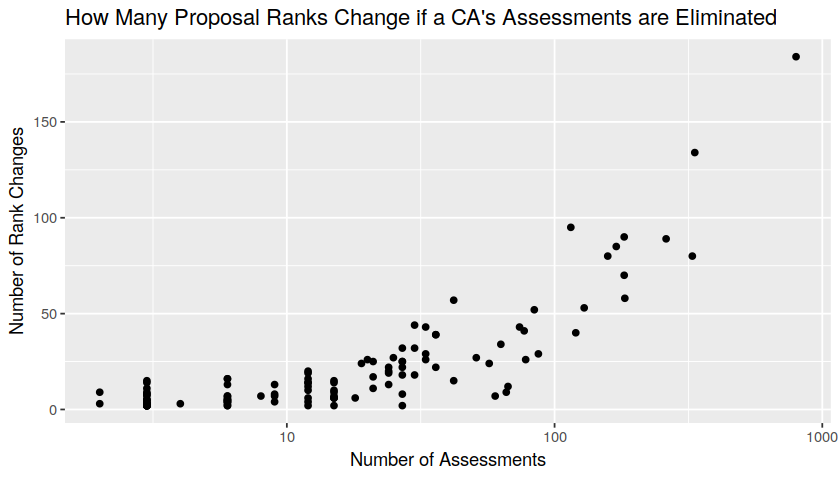

In [20]:
ggplot(
    f5.perturbation[, .(
        `Number of Assessments` = sum(`Assessments`),
        `Number of Rank Changes` = sum(`Number of Rank Changes`)
    ), by = .(`CA ID`)],
    aes(x = `Number of Assessments`, y = `Number of Rank Changes`)
) +
geom_point() +
scale_x_log10() +
ggtitle("How Many Proposal Ranks Change if a CA's Assessments are Eliminated")

#### The plot below shows that on a *per assessment* basis, the very active CAs are not more influential than other CAs. In contrast, CAs who only assess a few proposals do affect ranking on a *per assessment* basis.

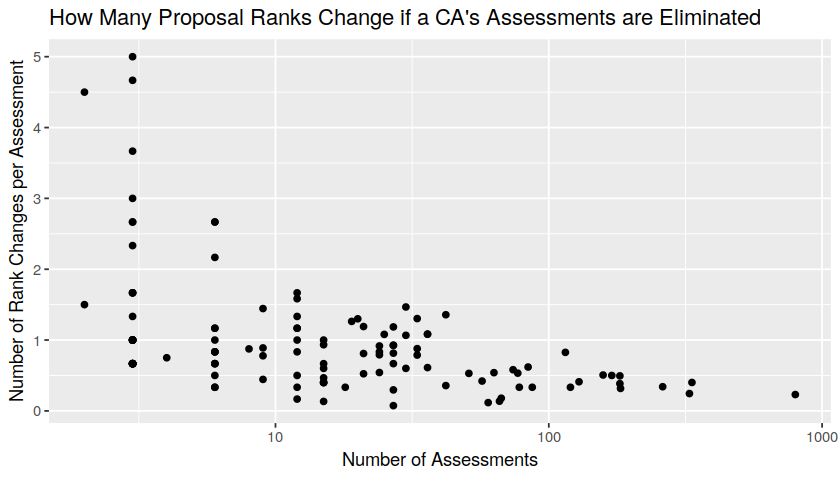

In [21]:
ggplot(
    f5.perturbation[, .(
        `Number of Assessments` = sum(`Assessments`),
        `Number of Rank Changes per Assessment` = sum(`Number of Rank Changes`) / sum(`Assessments`)
    ), by = .(`CA ID`)][order(- `Number of Rank Changes per Assessment`)],
    aes(x = `Number of Assessments`, y = `Number of Rank Changes per Assessment`)
) +
    geom_point() +
    scale_x_log10() +
ggtitle("How Many Proposal Ranks Change if a CA's Assessments are Eliminated")

## Tentative conclusions.

1.  There is no evidence of that anonymous CAs are scoring one proposal high and several other proposals low.
    *   There are 10 cases where a CA only assesses one proposal and gives it three 5-star ratings.
    *   There are about 5 cases where a CA scored one proposal high and one or two low, but this could be a result of the CA having assessed just a couple of proposals.
2.  There is no CA so influential that eliminating their scores would alter the list of the most highly scored proposals in each challeng area.
    *   In fact, there is no CA so influential that eliminating their scores would alter the set of nine highest scored proposals in each challenge area.
    *   However, there are quite a few CAs where eliminating the CA would affect the set of top *ten* highest scored proposals in challenge areas.
3.  CAs that score many proposals do substantially affect the ranking of all of the proposals in each challenge, but *per assessment* they do not substantially affect the ranking.
    *   This means that very active CAs have widespread influence overall, but not on a *per assessment* basis, where they are actually less influential than less active CAs.
    *   Some CAs that assess just a few proposals are more influential on a *per assessment* basis.

## Forensics on a closely correlated cluster of CAs.

Investigate the correlation between CAs 100, 62, 63, 74, 108, 91, 194.

In [22]:
f5cluster = c(100, 62, 63, 74, 108, 91, 194)

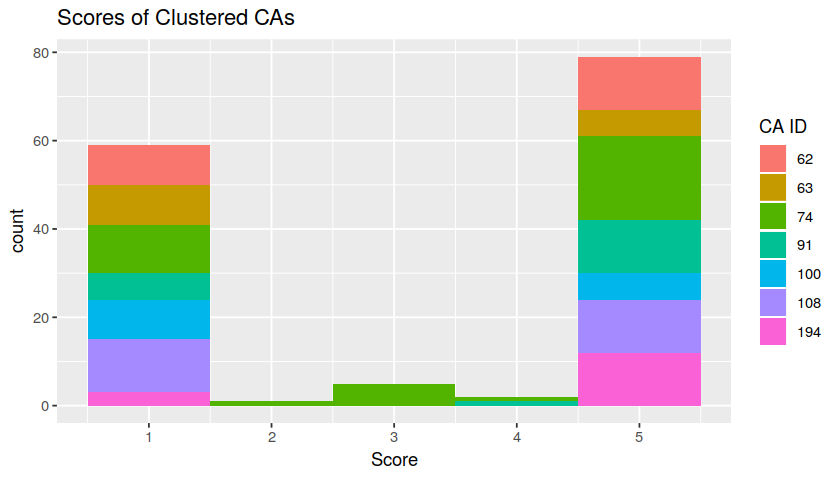

In [23]:
ggplot(
    f5[`CA ID` %in% f5cluster, .(`CA ID` = factor(`CA ID`), `Score`)],
    aes(x = `Score`, fill = `CA ID`)
) +
geom_histogram(bins = 5) +
ggtitle("Scores of Clustered CAs")

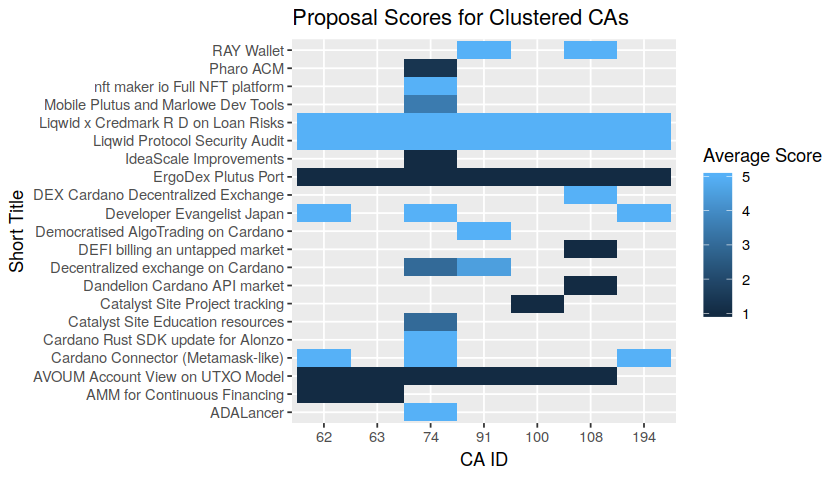

In [24]:
ggplot(
    f5[`CA ID` %in% c(100, 62, 63, 74, 108, 91, 194), .(`Average Score` = mean(`Score`)), by = .(`CA ID` = factor(`CA ID`), `Short Title` = factor(`Short Title`))],
    aes(x = `CA ID`, y = `Short Title`, fill = `Average Score`)
) +
geom_tile() +
ggtitle("Proposal Scores for Clustered CAs")

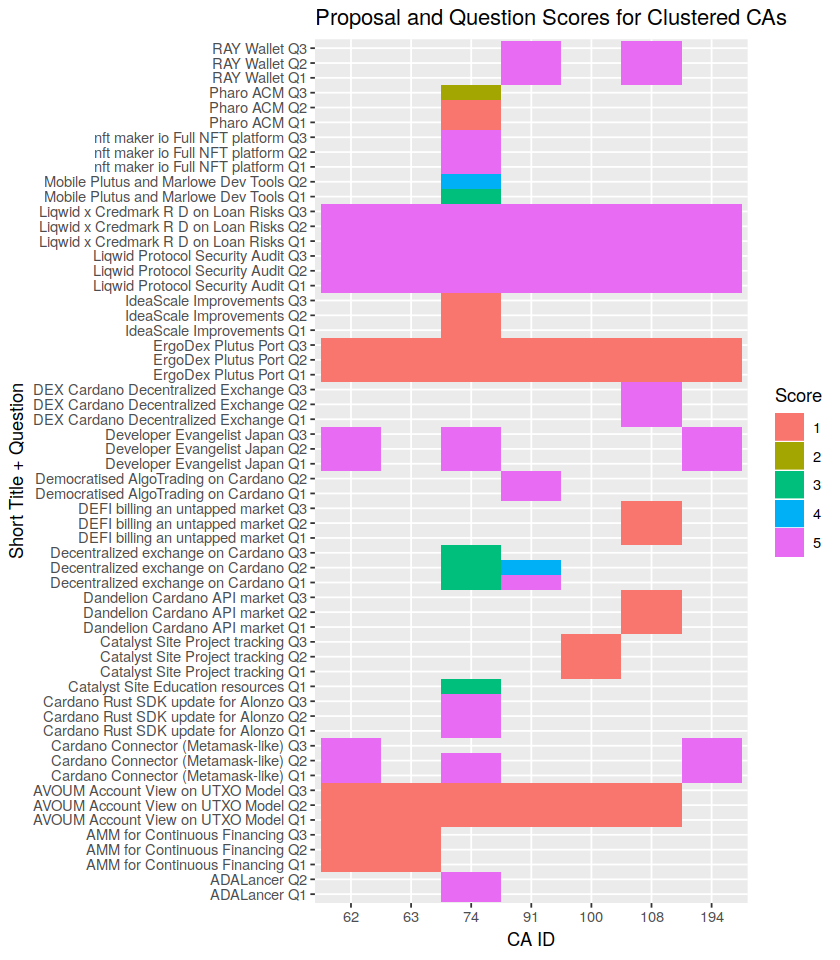

In [25]:
options(repr.plot.height=8)
ggplot(
    f5[
        `CA ID` %in% f5cluster,
        .(
        `CA ID` = factor(`CA ID`),
        `Short Title + Question` = factor(paste(`Short Title`, " Q", `Question ID`, sep = "")),
        `Score` = factor(`Score`)
        )
    ],
    aes(x = `CA ID`, y = `Short Title + Question`, fill = `Score`)
) +
geom_tile() +
ggtitle("Proposal and Question Scores for Clustered CAs")
options(repr.plot.height=4)

### This cluster does not affect the top-scored proposals.

In [26]:
f5topWithCluster    <- topRanked(f5, 1)
f5topWithoutCluster <- topRanked(f5[!(`CA ID` %in% f5cluster)], 1)
setdiff(f5topWithCluster, f5topWithoutCluster)

character(0)

No output from the above command indicates no changes.

### This cluster does affect the two top-scored proposals.

#### The Cardano Connector proposal is no longer in the two top.

In [27]:
f5topWithCluster    <- topRanked(f5, 2)
f5topWithoutCluster <- topRanked(f5[!(`CA ID` %in% f5cluster)], 2)
f5[`Unique Proposal ID` %in% setdiff(f5topWithCluster, f5topWithoutCluster), unique(`Short Title`)]

[1] "Cardano Connector (Metamask-like)"

#### That is replaced by the DaPassword proposal.

In [28]:
f5[`Unique Proposal ID` %in% setdiff(f5topWithoutCluster, f5topWithCluster), unique(`Short Title`)]

[1] "DaPassword a password manager"

In [29]:
af <- topRanked(f5[!(`CA ID` %in% f5cluster)], 1)

### How did other CAs rank these same proposals?

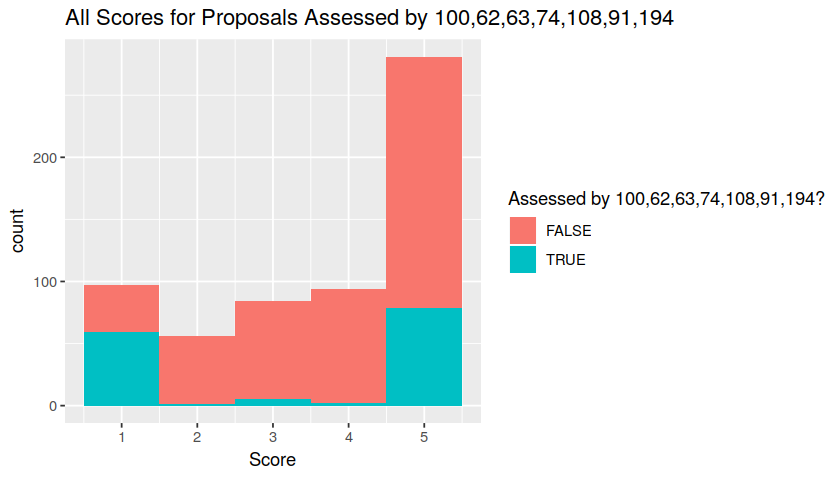

In [30]:
f5siblings <- f5[`CA ID` %in% f5cluster, unique(`Unique Proposal ID`)]
ggplot(
f5[
    `Unique Proposal ID` %in% f5siblings,
    .(
        `Assessed by 100,62,63,74,108,91,194?` = `CA ID` %in% c(100, 62, 63, 74, 108, 91, 194),
        `Score`,
        `Challenge`,
        `Short Title`
    )
], aes(
    x = `Score`,
    fill = `Assessed by 100,62,63,74,108,91,194?`
)) +
geom_histogram(bins = 5) +
ggtitle("All Scores for Proposals Assessed by 100,62,63,74,108,91,194")

## Clustering via dendrograms.

### Only consider cases where a CA made at least 10 assessments.

In [31]:
ss <- f5[, .N, by = .(`CA ID`)][N >= 10, `CA ID`]
length(ss)

[1] 74

In [32]:
z <- f5[
    `CA ID` %in% ss,
    .N,
    by = .(`Unique Proposal ID`, `Question ID`)
][, .(
    `Unique Proposal ID`,
    `Question ID`,
    Index = sequence(.N)
)]

In [33]:
w <- merge(
    z,
    f5[`CA ID` %in% ss, .(`Unique Proposal ID`, `Question ID`, `CA ID`, `Score`)],
    by = c("Unique Proposal ID", "Question ID"),
    all.x = TRUE,
    all.y = FALSE
)

In [34]:
u <- dcast(w, `Index` ~ `CA ID`, value.var = "Score", fill = NA)
u$Index <- NULL
u <- as.matrix(u)

In [35]:
v <- matrix(NA, nrow = length(ss), ncol = length(ss))
rownames(v) <- colnames(u)
colnames(v) <- colnames(u)
cmp <- function(x, y) {
    if (TRUE)
        x == y
    else
        (x > 3 & y > 3) | (x < 3 & y < 3) | (x == 3 & y == 3)
}
for (i in 1:length(ss))
    for (j in 1:length(ss)) {
        ui <- u[, i]
        uj <- u[, j]
#       v[i, j] <- length(ui) - length(which(as.vector(ui == uj)))
        v[i, j] <- length(which(!is.na(ui) | !is.na(uj))) - length(which(as.vector(cmp(ui, uj))))
    }
v <- as.dist(v)

In [36]:
vp <- hclust(v, method = "ward.D")

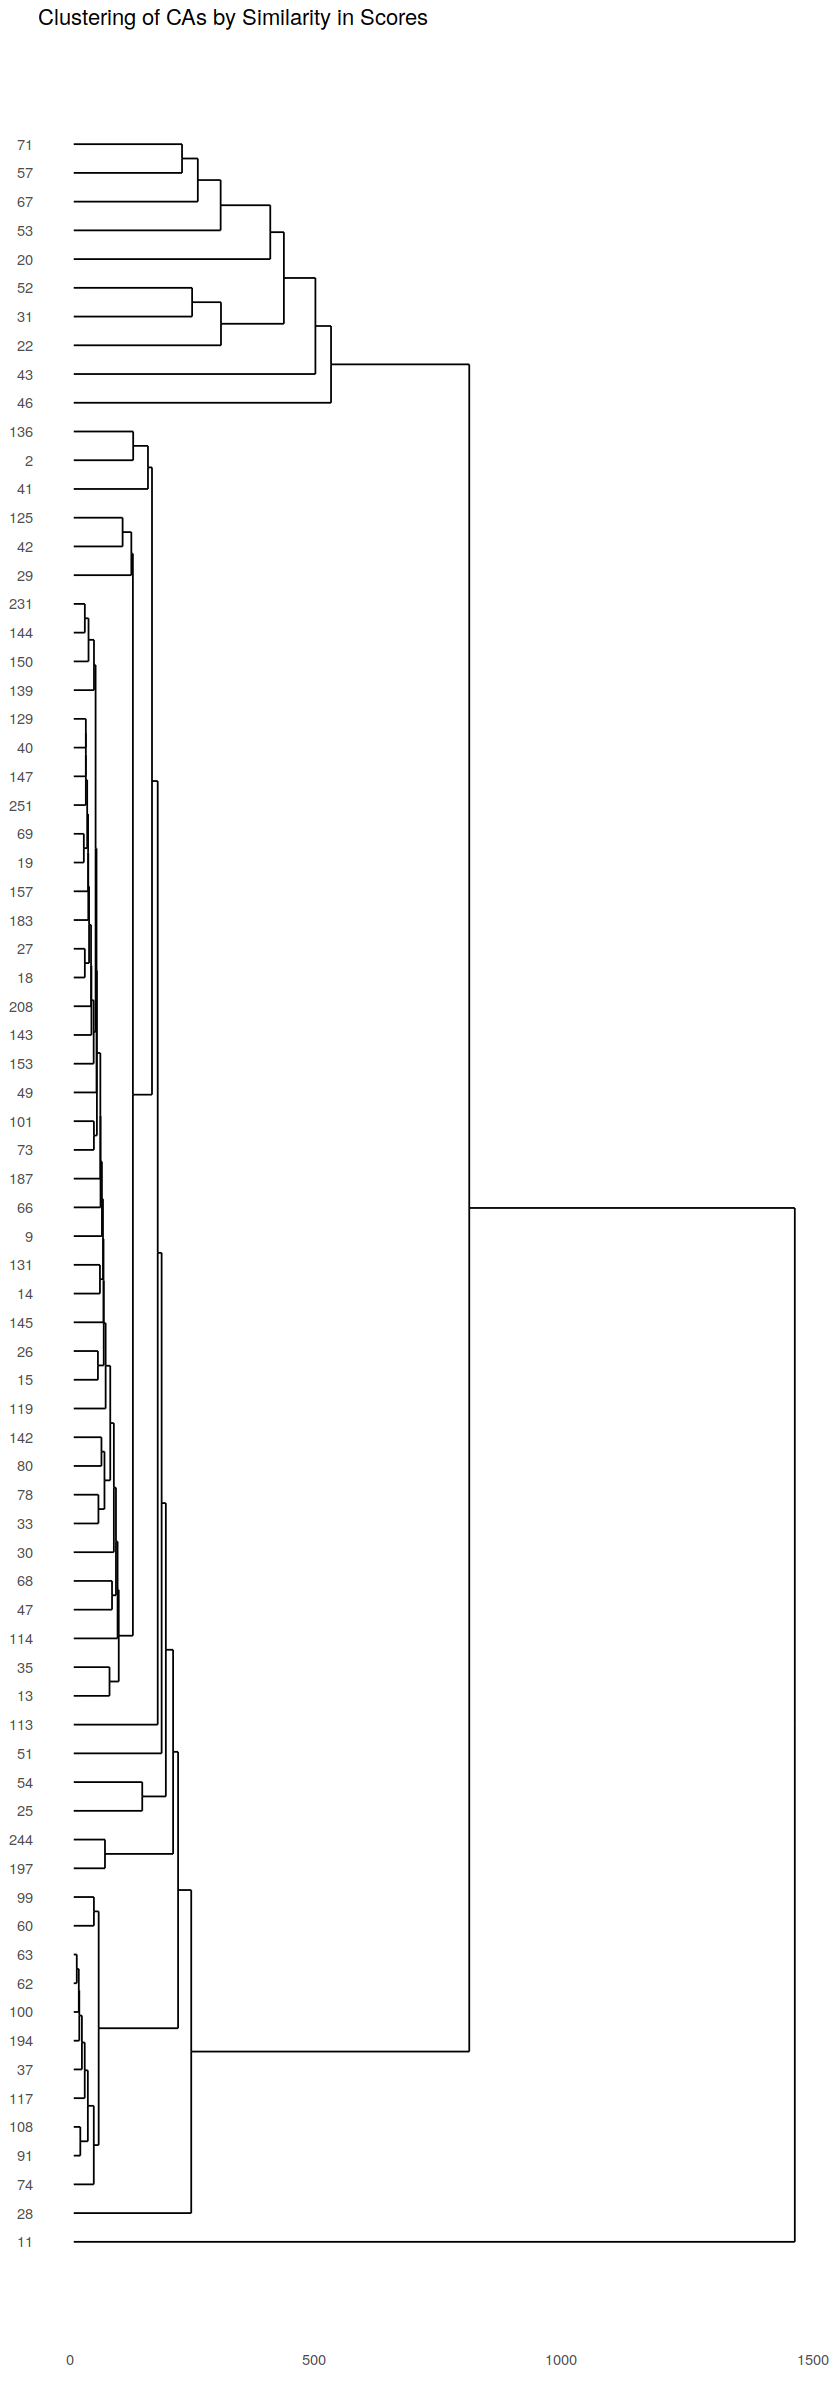

In [37]:
options(repr.plot.height=20)
ggdendrogram(vp, rotate = TRUE) +
ggtitle("Clustering of CAs by Similarity in Scores")
options(repr.plot.height=4)